In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.svm import LinearSVC

파싱

In [2]:
#파싱을 진행하는 함수
def parsing(path):
    with open(path,'r',encoding='utf-8') as f:
        train=[]
        head = ["POST","PUT"]
        l = f.readlines()
        for i in range(len(l)):
          line = l[i].split()
          if len(line)!= 0:
            if line[0] == "GET":
              train.append(line[0]+line[1])
            elif line[0] in head:
              j=1
              while True:
                j+=1
                if l[i+j].startswith("Content-Length:"):
                  break
              train.append(line[0]+line[1]+"?"+l[i+j+2])
            
    return train

In [3]:
def dataset(path,mod='train'): #데이터셋을 생성합니다. 파싱한 데이터와 라벨을 생성합니다 
    x = parsing(f'{path}norm_{mod}.txt') # mod에 따라 train을 가져올지 test 데이터를 가져올지 결정됩니다.
    y = [0]*len(x) # 정상 라벨 0 을 정상 데이터 개수 만큼 생성
    x += parsing(f'{path}anomal_{mod}.txt')
    y += [1]*(len(x)-len(y)) # 비정상 라벨 1을 비정상 데이터 개수 만큼 생성
    return x, y

In [4]:
def vectorize(train_x,test_x): #문장을 벡터로 만듭니다 해당 코드에서는 기본적인 tf idf를 사용하고 있습니다.
    tf = TfidfVectorizer()
    tf = tf.fit(train_x)
    train_vec = tf.transform(train_x)
    test_vec = tf.transform(test_x)
    return train_vec,test_vec

In [5]:
def train(train_vec,train_y): #랜덤 포레스트로 훈련 시킵니다. 모델을 바꾸고 싶다면 이 함수를 변경해야 합니다.
    rf = RandomForestClassifier(200)
    rf.fit(train_vec,train_y)
    return rf

In [6]:
#입력 받은 테스트와 모델로 테스트를 실시합니다
def test(test_y,test_vec,test): 
    pred = test.predict(test_vec)
    fpr, tpr, thresholds = roc_curve(test_y,pred)
    roc_auc = roc_auc_score(test_y, pred)
    
    plt.plot(fpr, tpr, label=type(test).__name__.split('.')[-1])
    plt.plot([0,1],[0,1],'--',color='black')
    plt.title('ROC Corve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    print("accuracy_score: ",accuracy_score(test_y,pred))
    print("f1_score: \t",f1_score(test_y,pred))
    print()
    return pred, [type(test).__name__.split('.')[-1],roc_auc]

In [7]:
from sklearn.linear_model import LogisticRegression
def lgs_train(train_vec,train_y):
    lgs = LogisticRegression(solver='lbfgs', max_iter=1000)
    lgs.fit(train_vec,train_y)
    return lgs

from sklearn import tree
def dt_train(train_vec,train_y):
    dt = tree.DecisionTreeClassifier()
    dt.fit(train_vec,train_y)
    return dt

from sklearn.svm import LinearSVC
def svm_train(train_vec,train_y):
    svm = LinearSVC(C=1)
    svm.fit(train_vec,train_y)
    return svm

from sklearn.ensemble import RandomForestClassifier
def rf_train(train_vec,train_y):
    rf = RandomForestClassifier(200)
    rf.fit(train_vec,train_y)
    return rf

test on Logistic Regresstion
accuracy_score:  0.9760910505199377
f1_score: 	 0.9706473663047849

test on RandomForest
accuracy_score:  0.9656922950953901
f1_score: 	 0.9592531362442868

test on DecisionTree
accuracy_score:  0.9656104151314173
f1_score: 	 0.9589362534219789

test on Linear_SVM
accuracy_score:  0.9945959223777942
f1_score: 	 0.993382795267696

AUC score
                      모델명       AUC
0      LogisticRegression  0.974117
1  RandomForestClassifier  0.968449
2  DecisionTreeClassifier  0.967531
3               LinearSVC  0.993629


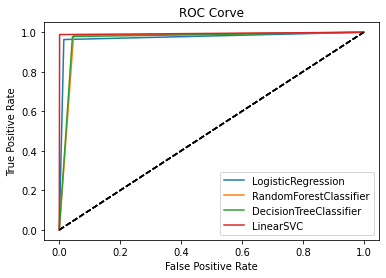

In [8]:
############### 실행 코드 #######################
################################################
rows=[]
train_x, train_y = dataset('../data','train')
test_x, test_y =  dataset('../data','test')
train_vec, test_vec = vectorize(train_x, test_x)


print("test on Logistic Regresstion")
lgs = lgs_train(train_vec, train_y)
pred, lgs_row = test(test_y,test_vec, lgs)
rows.append(lgs_row)

print("test on RandomForest")
rf = rf_train(train_vec, train_y)
pred, rf_row = test(test_y,test_vec, rf)
rows.append(rf_row)

print("test on DecisionTree")
dt = dt_train(train_vec, train_y)
pred, dt_row = test(test_y,test_vec, dt)
rows.append(dt_row)

print("test on Linear_SVM")
svm = svm_train(train_vec, train_y)
pred,svm_row = test(test_y,test_vec, svm)
rows.append(svm_row)

print("AUC score")
df = pd.DataFrame(rows, columns=['모델명','AUC'])
df.sort_values(by='AUC',ascending=False)
print(df)
########################################################